In [1]:

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, Function

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D

# Import from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Import FBP from CIL recon class
from cil.recon import FBP

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Load the example data set
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

# Preprocessing
scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale
data_sync = TransmissionAbsorptionConverter()(data_sync)
data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

# Crop data and reorder for ASTRA backend
data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)
data90.reorder(order='astra')

# Set up and run FBP for 90-angle dataset
recon90 = FBP(data90, backend='astra').run(verbose=0)

# Set up and run FBP for 15-angle dataset
data15 = Slicer(roi={'angle': (0,90,6)})(data90)
recon15 = FBP(data15, backend='astra').run(verbose=0)

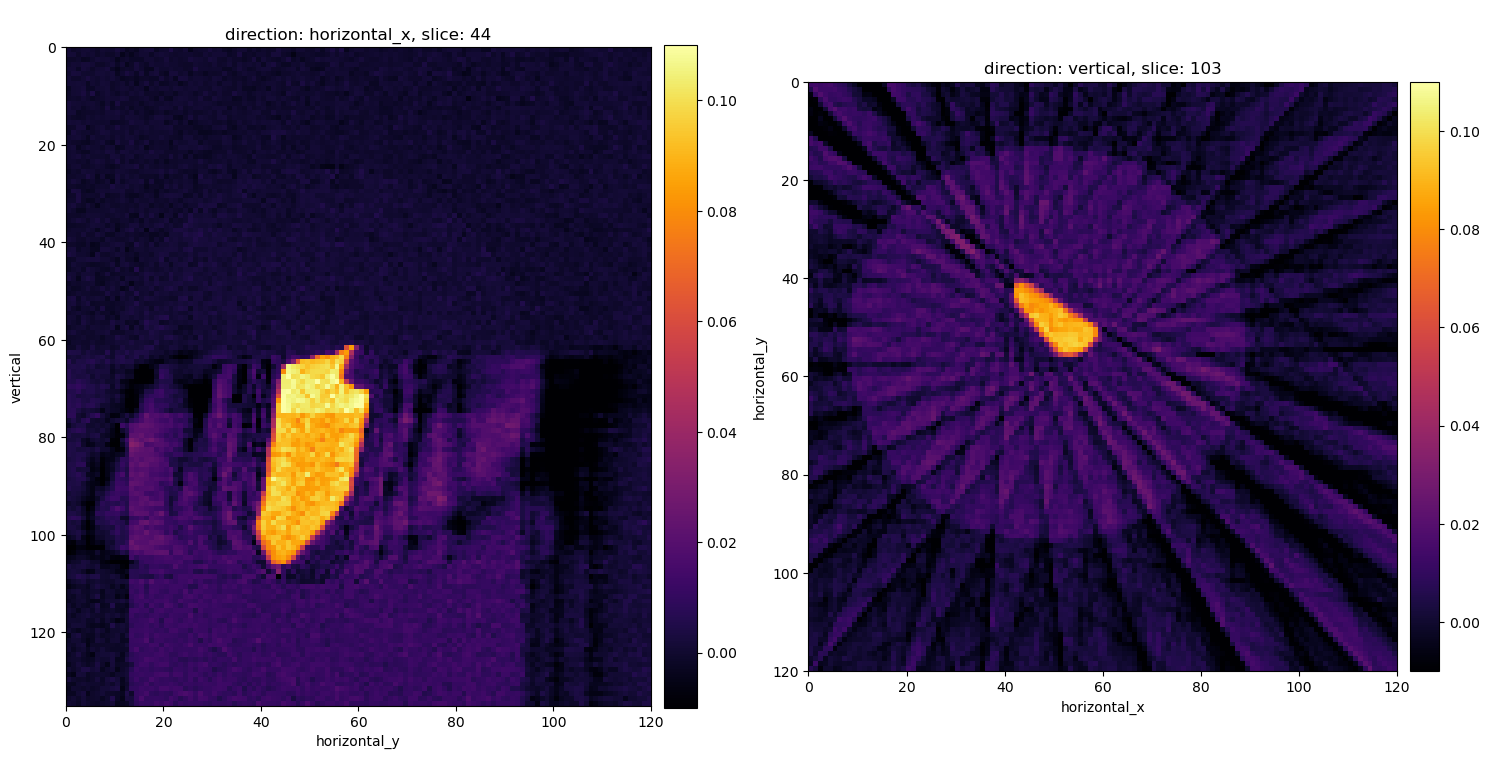

In [3]:
# Define custom parameters for show2D for visualizing all reconstructions consistently
sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11
slices = [('horizontal_x',sx),('vertical',sz)]

show2D(recon15, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

## FISTA - TV 

In [4]:
ag = data15.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag, device="gpu")
b = data15

F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha = 0.02
GTV = alpha*FGP_TV(device='gpu', nonnegativity=True) 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

  0%|          | 0/200 [00:00<?, ?it/s]

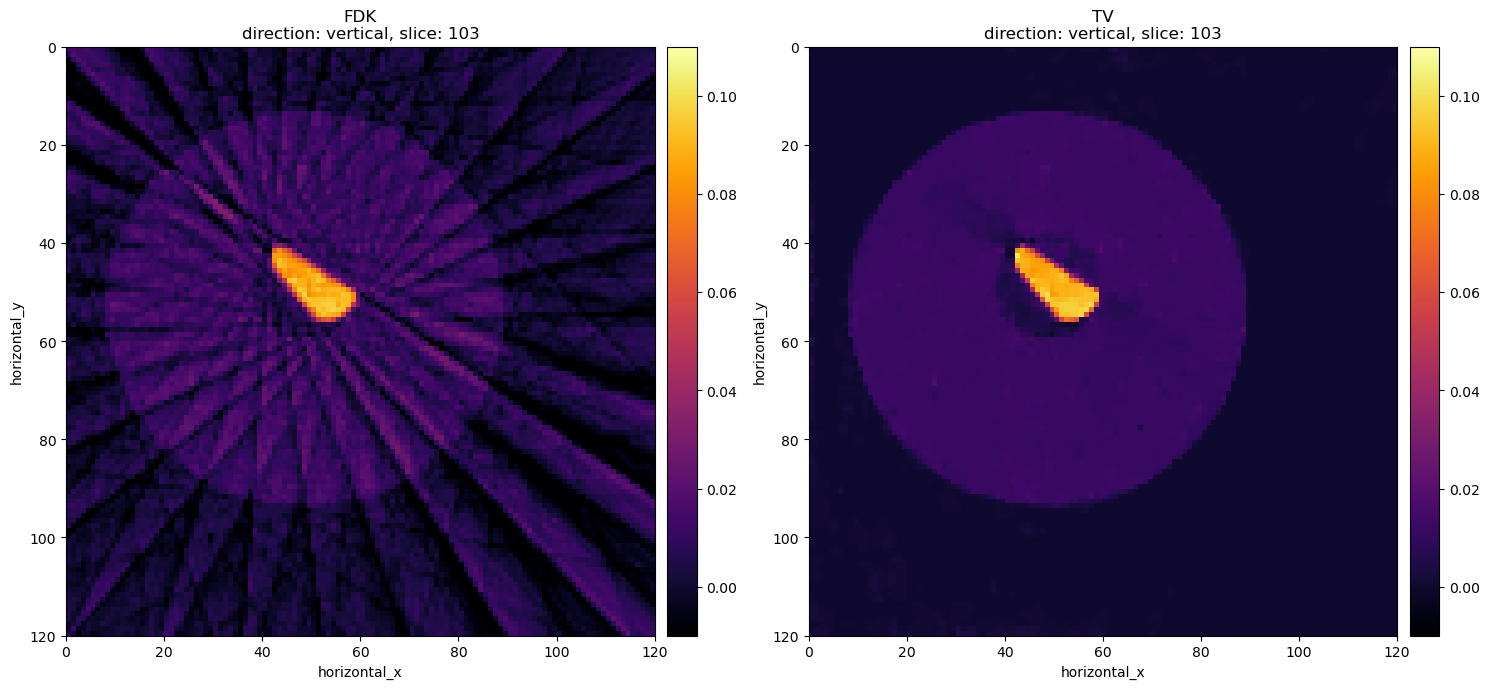

In [5]:
show2D([recon15, myFISTATV.solution ], title=['FDK', 'TV'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


# FISTA with the proximal step a learned denoiser - DnCCN - non noise level aware

In [6]:
from deepinv.models import DnCNN
import torch
import deepinv

class DnCNNProximal(Function ):
    
    def __init__(self, device='cuda:1' ):
        self.device = torch.device('cuda:1')
        self.model = deepinv.models.DnCNN(in_channels=1, out_channels=1, pretrained='download_lipschitz', device=self.device)
        
        super(DnCNNProximal, self).__init__()

    def __call__(self, x):
        return 0 
    
    def proximal(self, x, tau, out=None): 
        x_torch = torch.tensor(x.array, device=self.device)
        x_torch = x_torch.squeeze(0).unsqueeze(1)
        out_torch = self.model(x_torch, tau)
        
        out_torch = out_torch.squeeze(1).unsqueeze(0)
        if out is None: 
            out = x.geometry.allocate(None)
            
        out.array[:] = out_torch.detach().cpu().numpy()
        return out 
        

  0%|          | 0/50 [00:00<?, ?it/s]

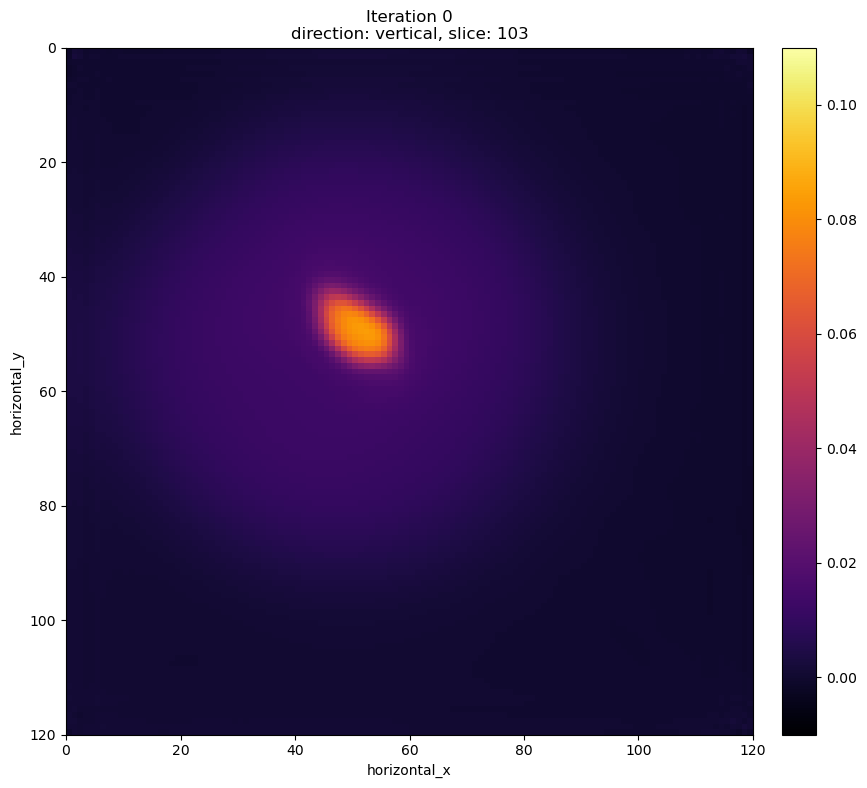

 51%|#####1    | 51/100 [00:00<?, ?it/s]

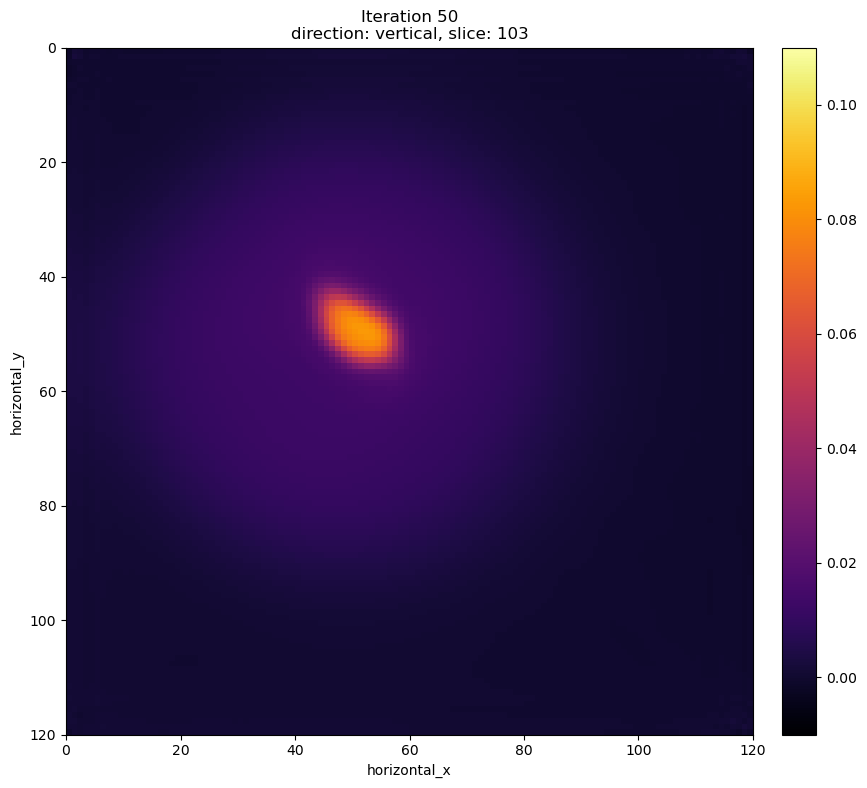

 67%|######7   | 101/150 [00:00<?, ?it/s]

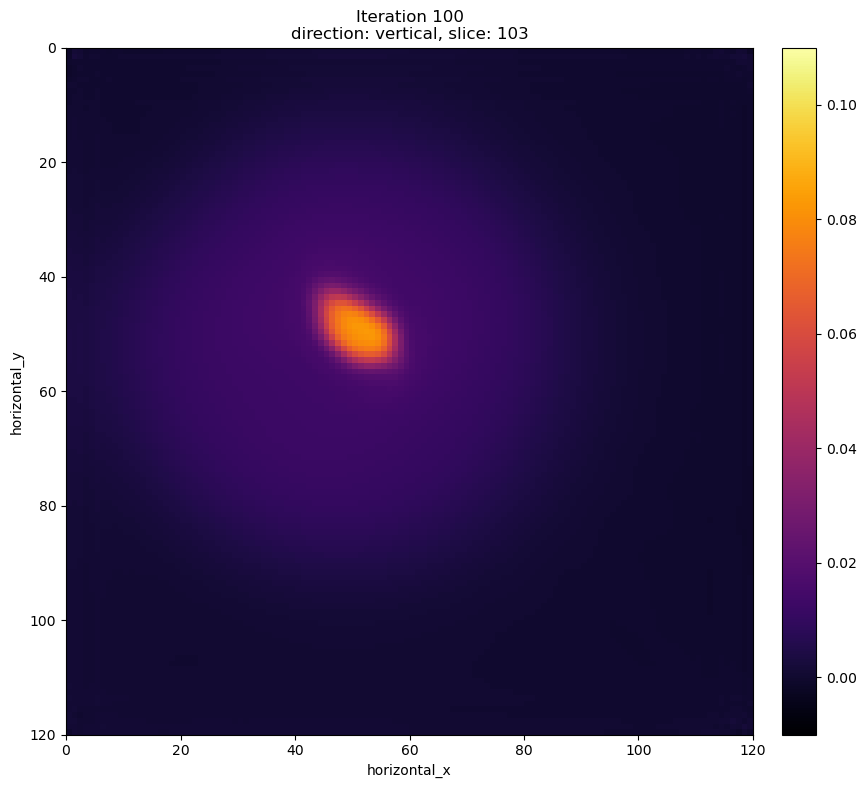

 76%|#######5  | 151/200 [00:00<?, ?it/s]

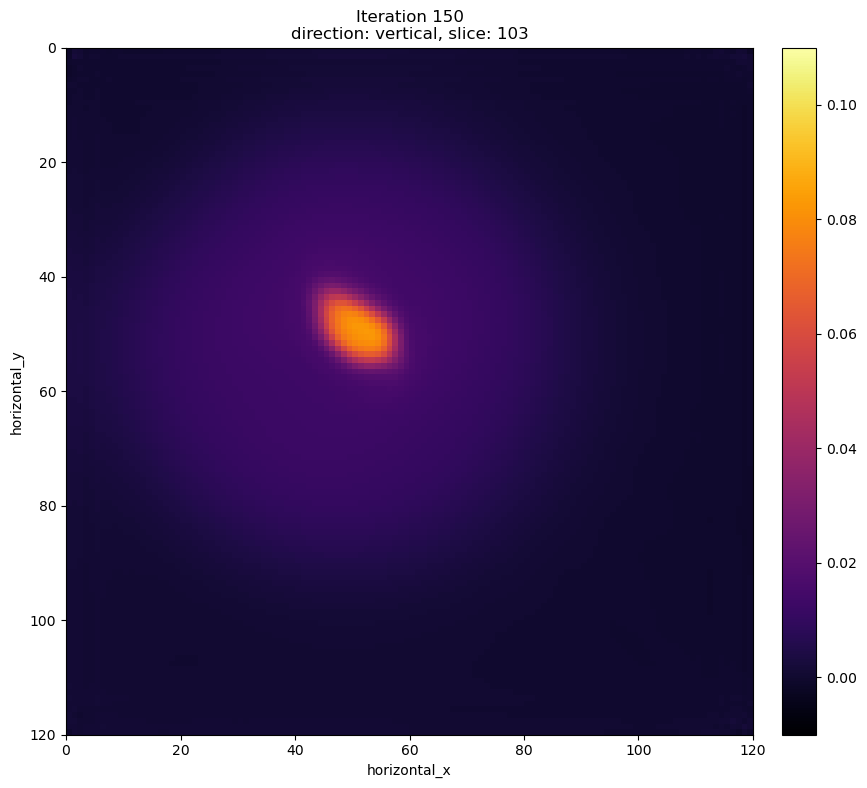

In [ ]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
Regulariser = DnCNNProximal()
#TODO: FISTA OR ISTA? 
myFISTADnCNN = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADnCNN.run(50,verbose=1)
    show2D(myFISTADnCNN.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


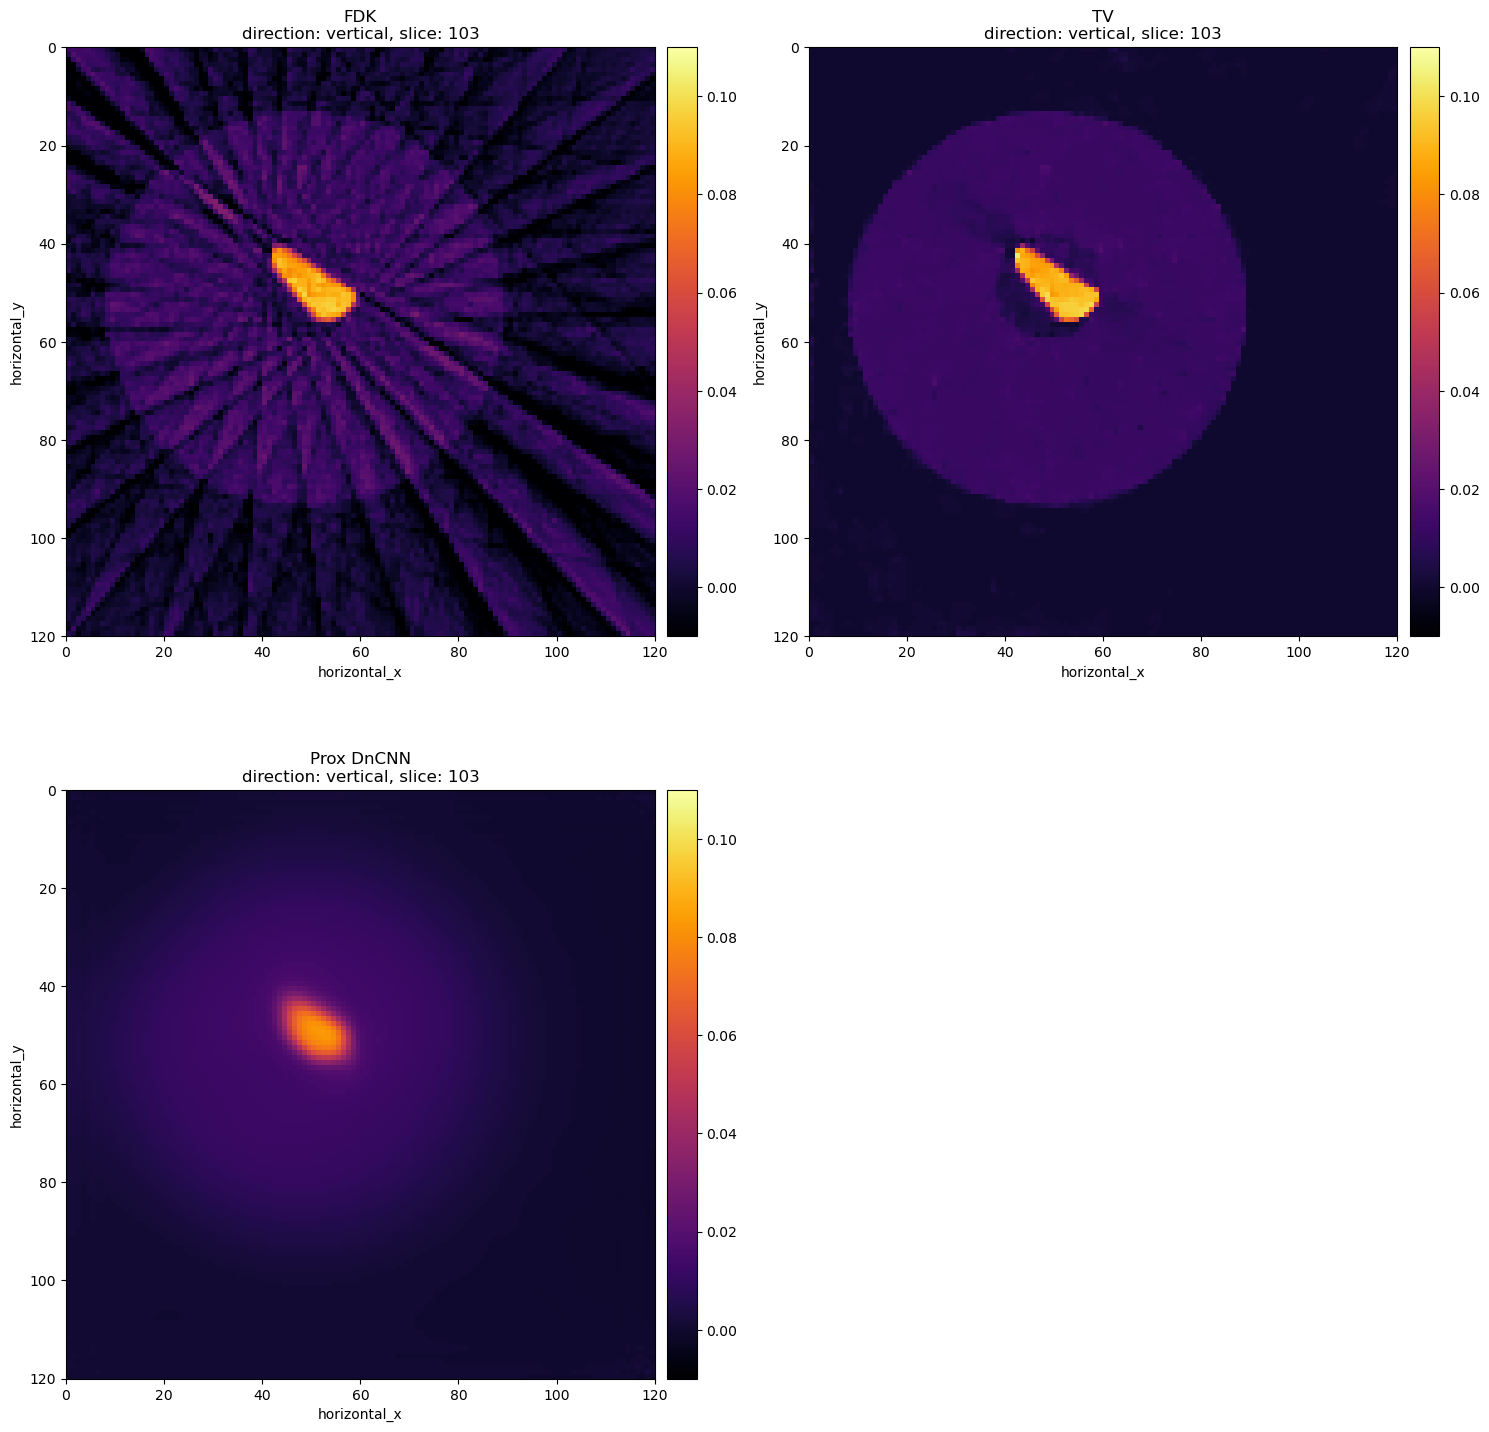

In [8]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution], title=['FDK', 'TV', 'Prox DnCNN'],
            slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


## FISTA with the proximal step a learned denoiser - DRUNet - noise level aware

In [ ]:
from deepinv.models import DRUNet
import torch
import deepinv

class DRUNetProximal2D(Function ):
    
    def __init__(self, device='cuda:1', batch_size=None ):
        self.device = torch.device('cuda:1')
        self.model = deepinv.models.DRUNet(in_channels=1, out_channels=1, pretrained='download', device=self.device)
        self.batch_size = batch_size
        super(DRUNetProximal2D, self).__init__()

    def __call__(self, x):
        return 0 
    
    #TODO: If batch size is NOne don't do the batching 
    #TODO: Not sure the batching is working, e.g for batch=50
    def proximal(self, x, tau, out=None): 
        with torch.no_grad():
            x_torch = torch.tensor(x.array, device=self.device)

            x_torch = x_torch.squeeze(0).unsqueeze(1)
            
            x_torch= self.model(x_torch, tau)
            
            #for i in range(x_torch.shape[0]//self.batch_size +1):
            #    try:
            #        x_torch[i*self.batch_size: (i+1)*self.batch_size] = self.model(x_torch[i*self.batch_size: (i+1)*self.batch_size], tau)
            #    except IndexError:
            #        x_torch[i*self.batch_size:] = self.model(x_torch[i*self.batch_size:], tau)
            
            x_torch = x_torch.squeeze(1).unsqueeze(0)
        
        
        if out is None: 
            out = x.geometry.allocate(None)
            

        out.array[:] = x_torch.detach().cpu().numpy()
        return out 
        

In [10]:
import gc

#Regulariser.model.to('cpu')
#del Regulariser
gc.collect()
torch.cuda.empty_cache()


### Too large regularisation parameter


  0%|          | 0/50 [00:00<?, ?it/s]

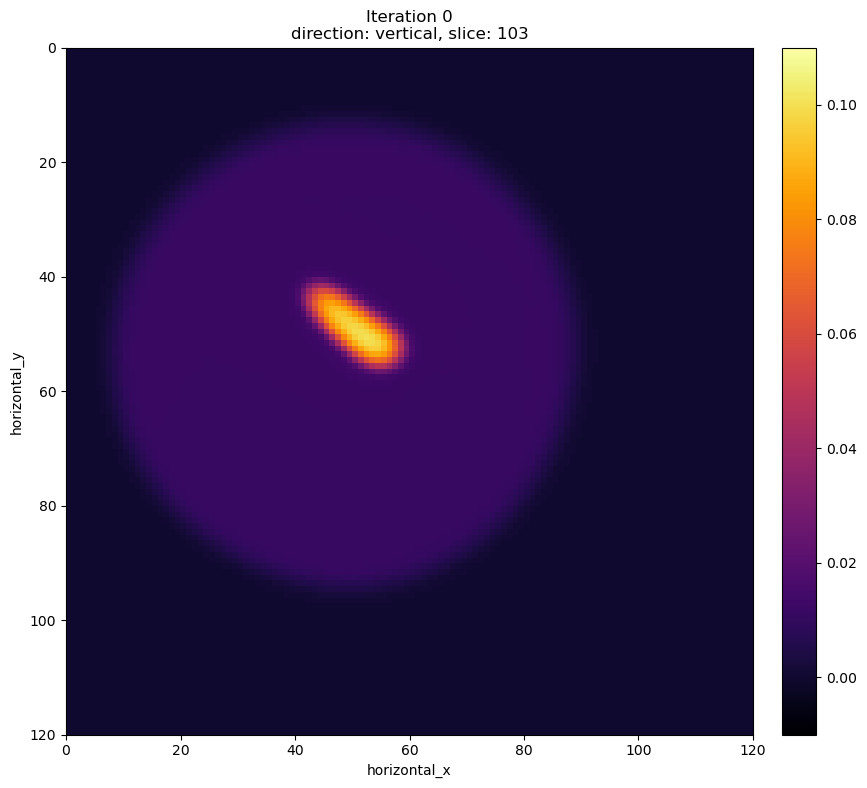

 51%|#####1    | 51/100 [00:00<?, ?it/s]

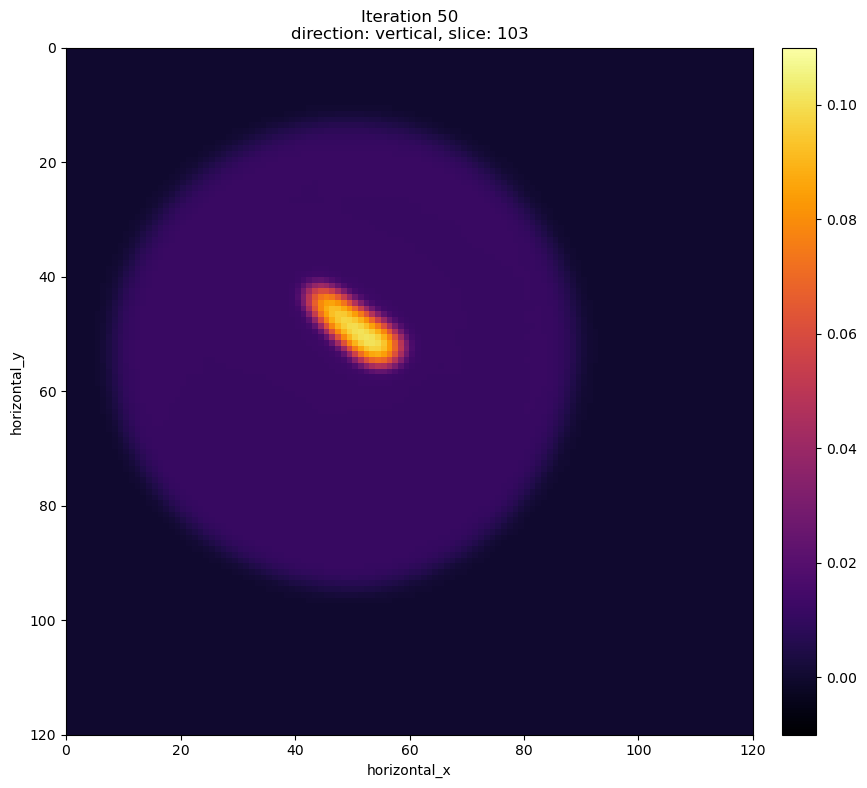

 67%|######7   | 101/150 [00:00<?, ?it/s]

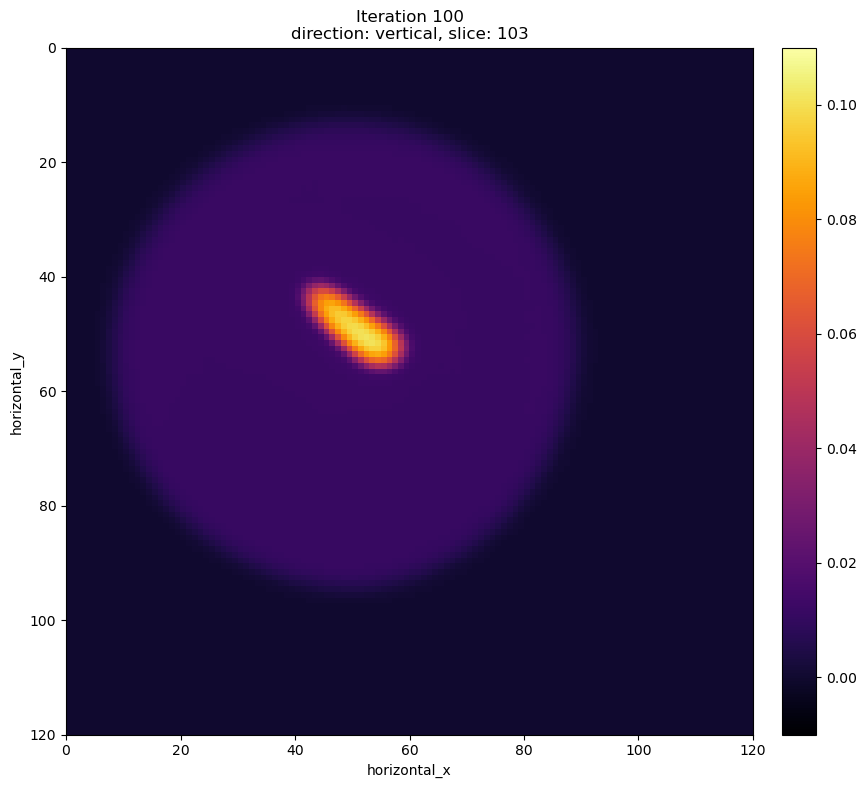

 76%|#######5  | 151/200 [00:00<?, ?it/s]

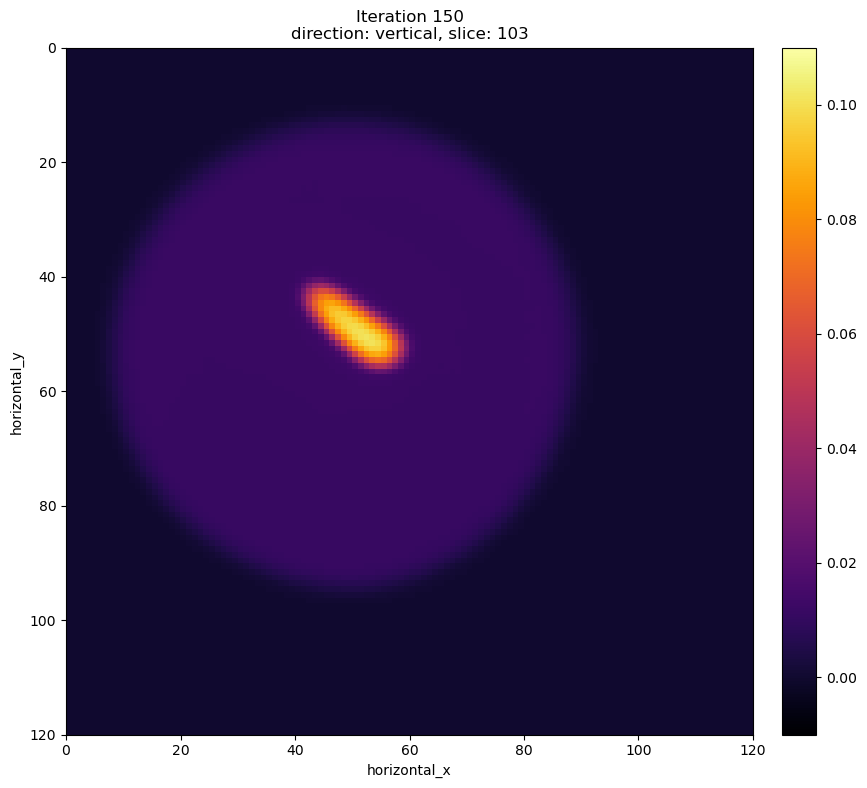

In [11]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha=20
Regulariser = alpha*DRUNetProximal2D(batch_size=5)
myFISTADRUNet2D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet2D.run(50,verbose=1)
    show2D(myFISTADRUNet2D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


### Too small regularisation parameter 

  0%|          | 0/50 [00:00<?, ?it/s]

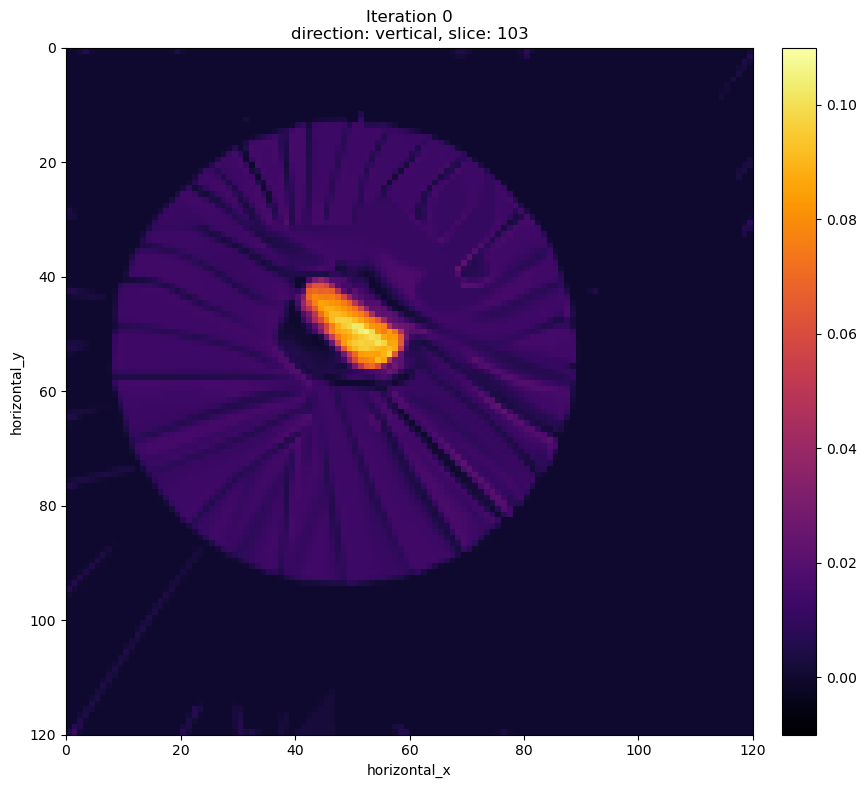

 51%|#####1    | 51/100 [00:00<?, ?it/s]

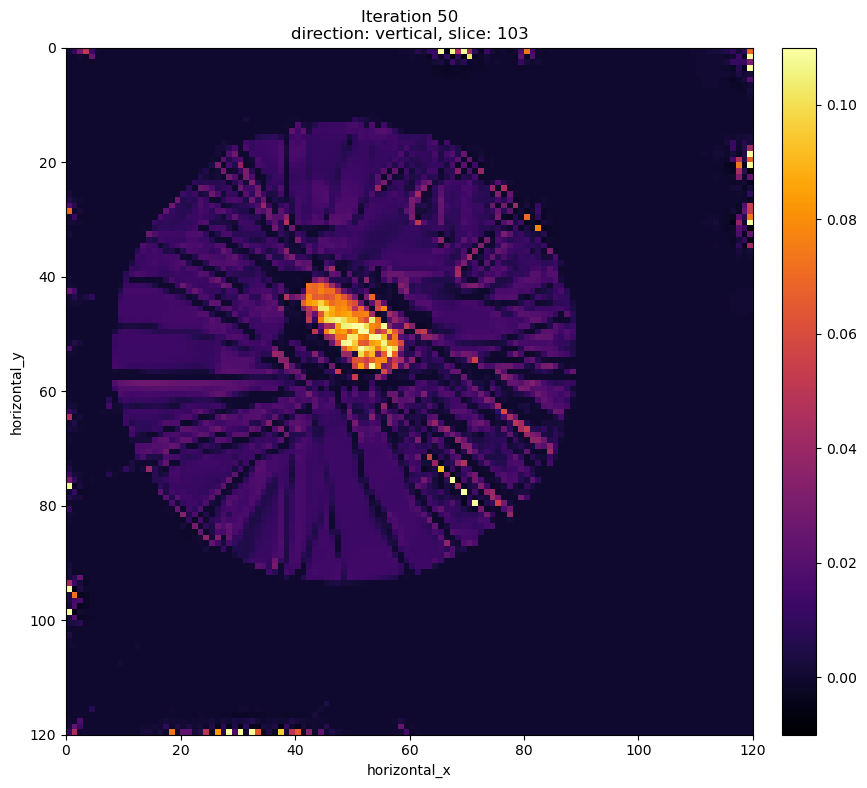

 67%|######7   | 101/150 [00:00<?, ?it/s]

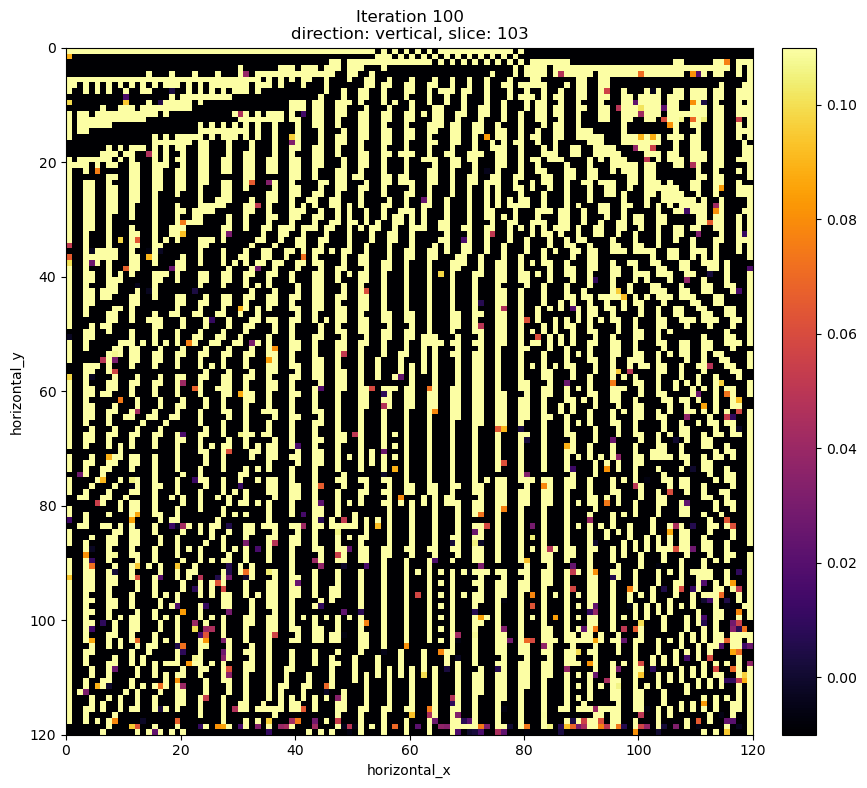

 76%|#######5  | 151/200 [00:00<?, ?it/s]

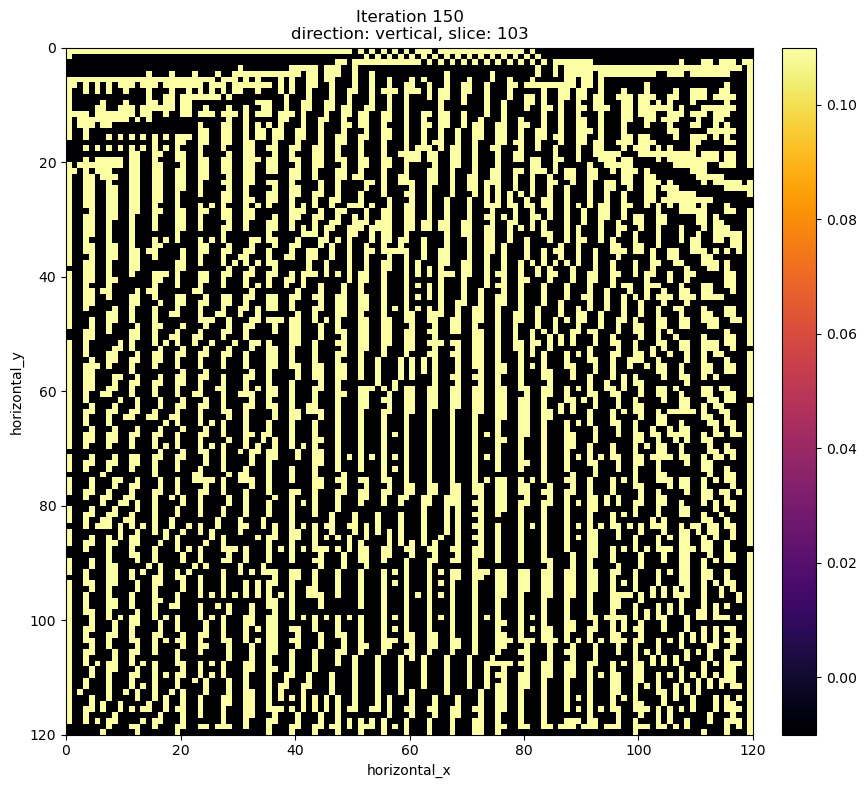

In [12]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha=0.5
Regulariser = alpha*DRUNetProximal2D(batch_size=5)
myFISTADRUNet2D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet2D.run(50,verbose=1)
    show2D(myFISTADRUNet2D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


In [ ]:
#TODO: why is it blowing up? Is DRUNet non-negative, is that where it is going wrong? 

### About right (?) regularisation parameter 

  0%|          | 0/50 [00:00<?, ?it/s]

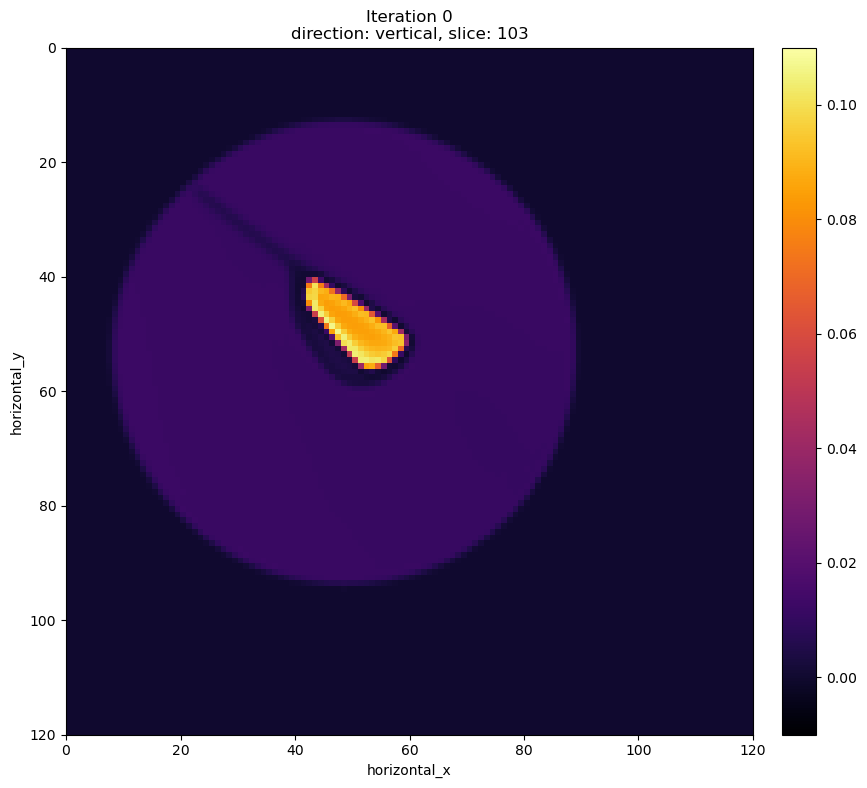

 51%|#####1    | 51/100 [00:00<?, ?it/s]

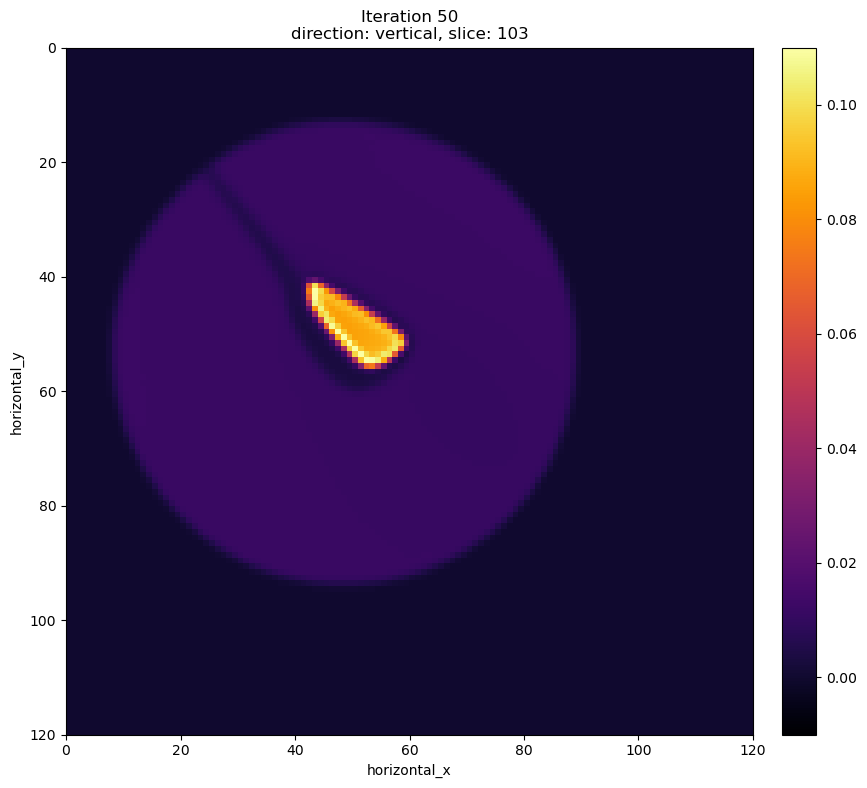

 67%|######7   | 101/150 [00:00<?, ?it/s]

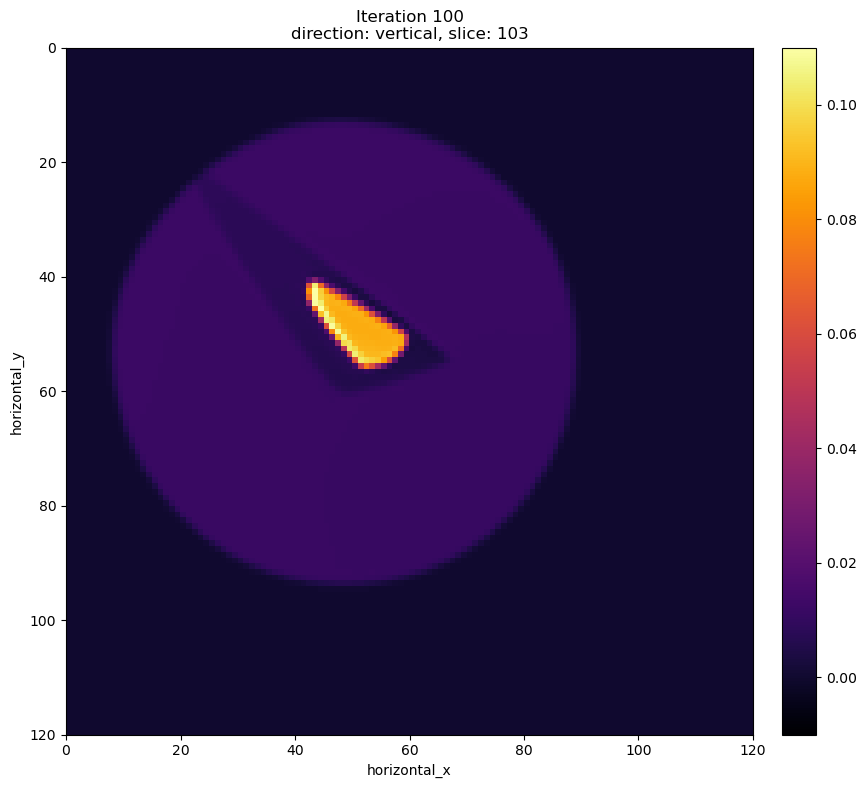

 76%|#######5  | 151/200 [00:00<?, ?it/s]

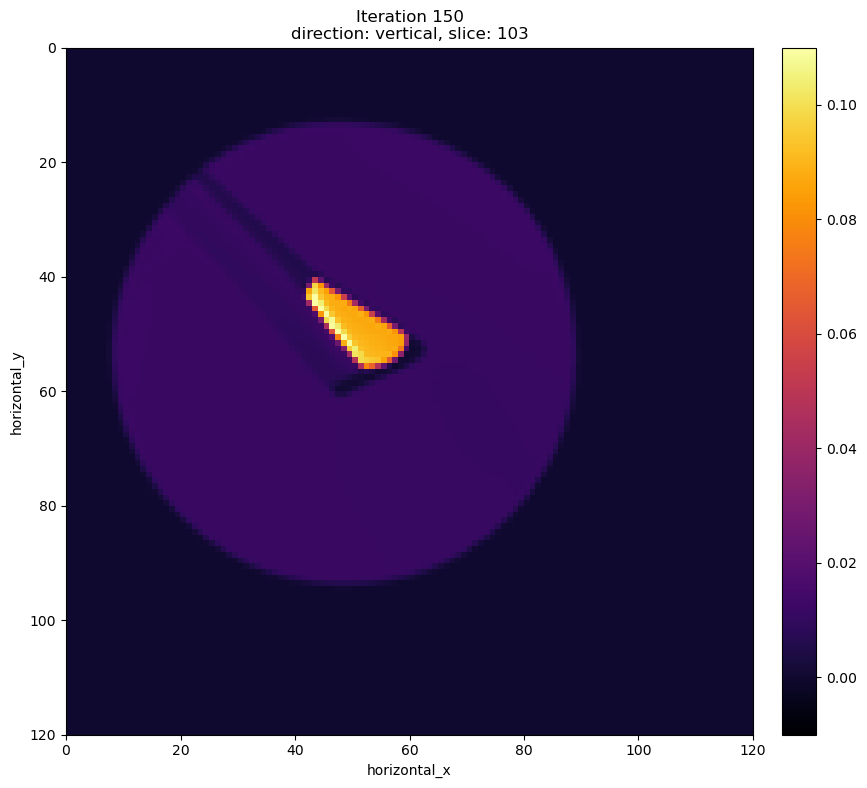

In [13]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha=3
Regulariser = alpha*DRUNetProximal2D(batch_size=5)
myFISTADRUNet2D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet2D.run(50,verbose=1)
    show2D(myFISTADRUNet2D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


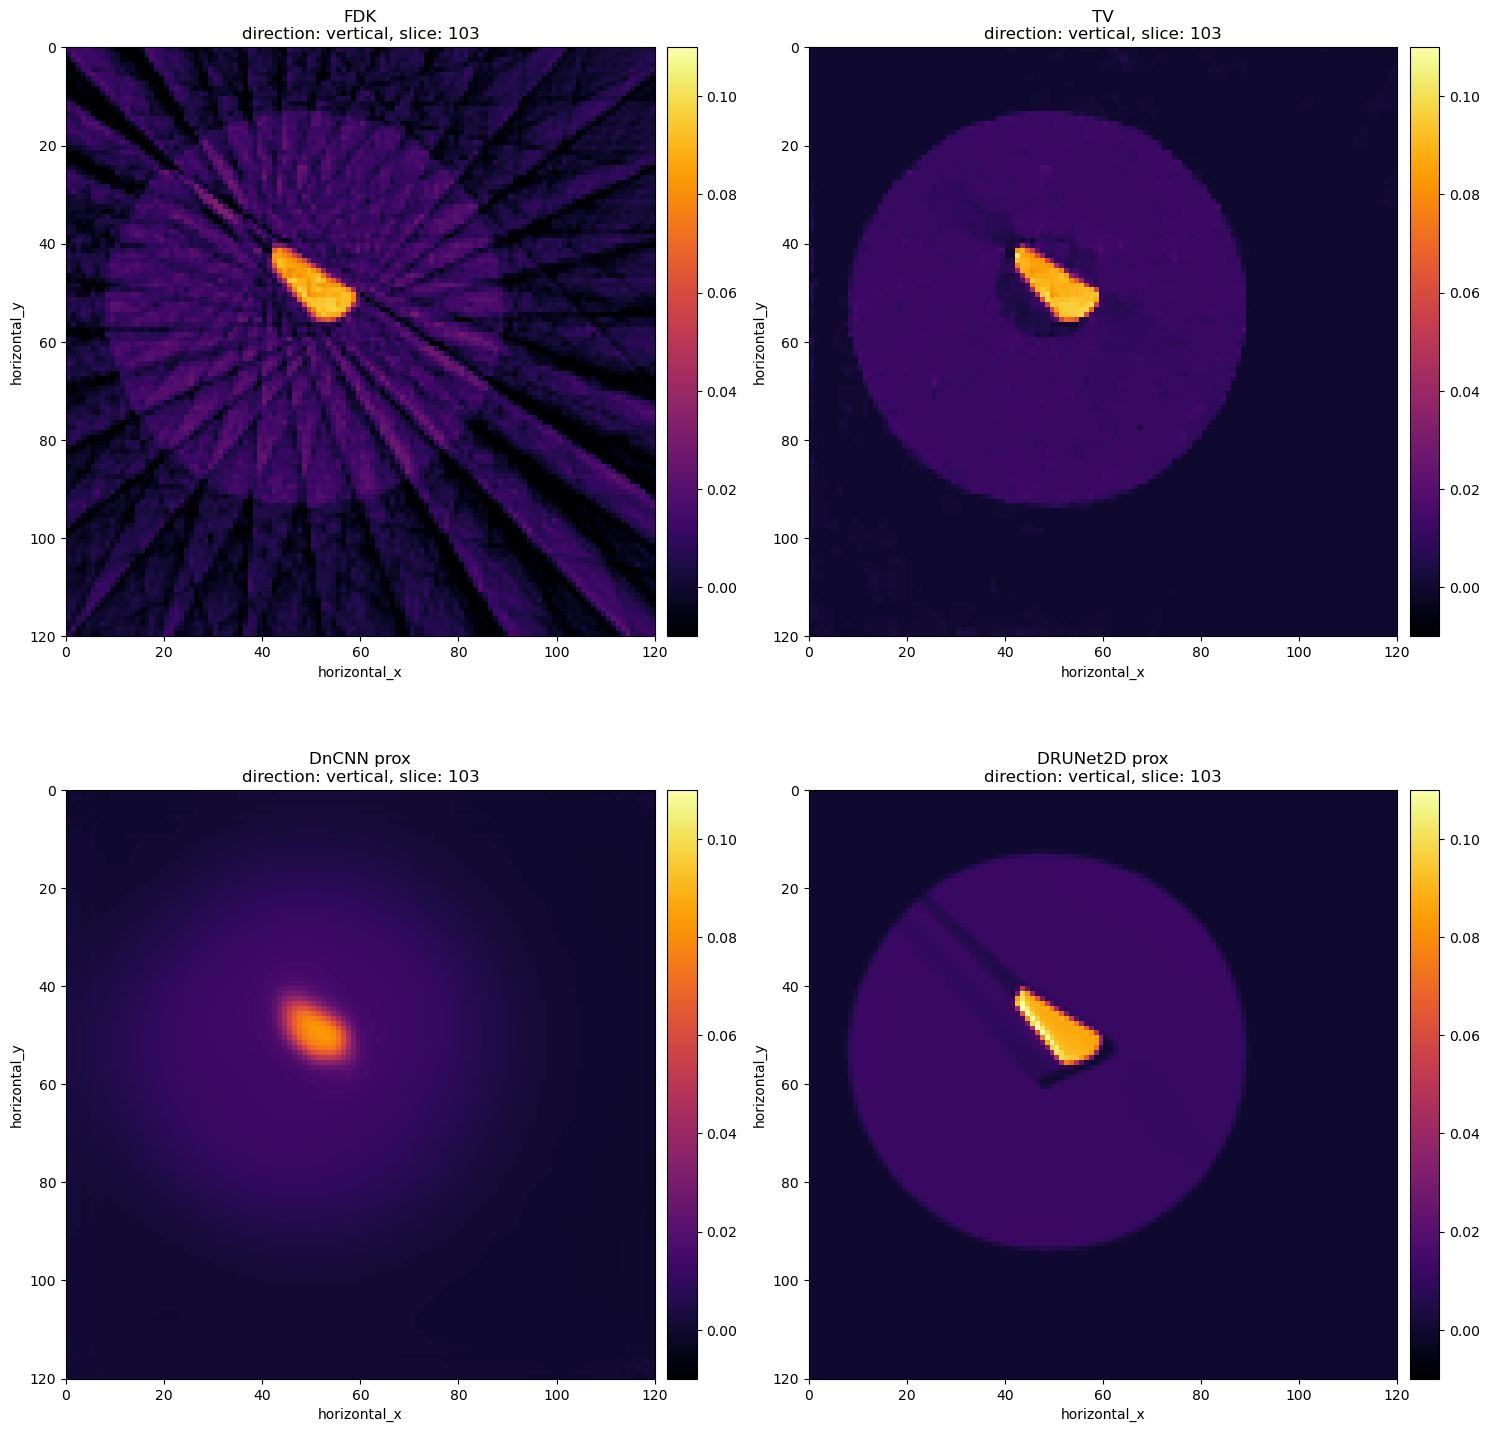

In [15]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution,  myFISTADRUNet2D.solution], title=['FDK', 'TV' , 'DnCNN prox', 'DRUNet2D prox'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

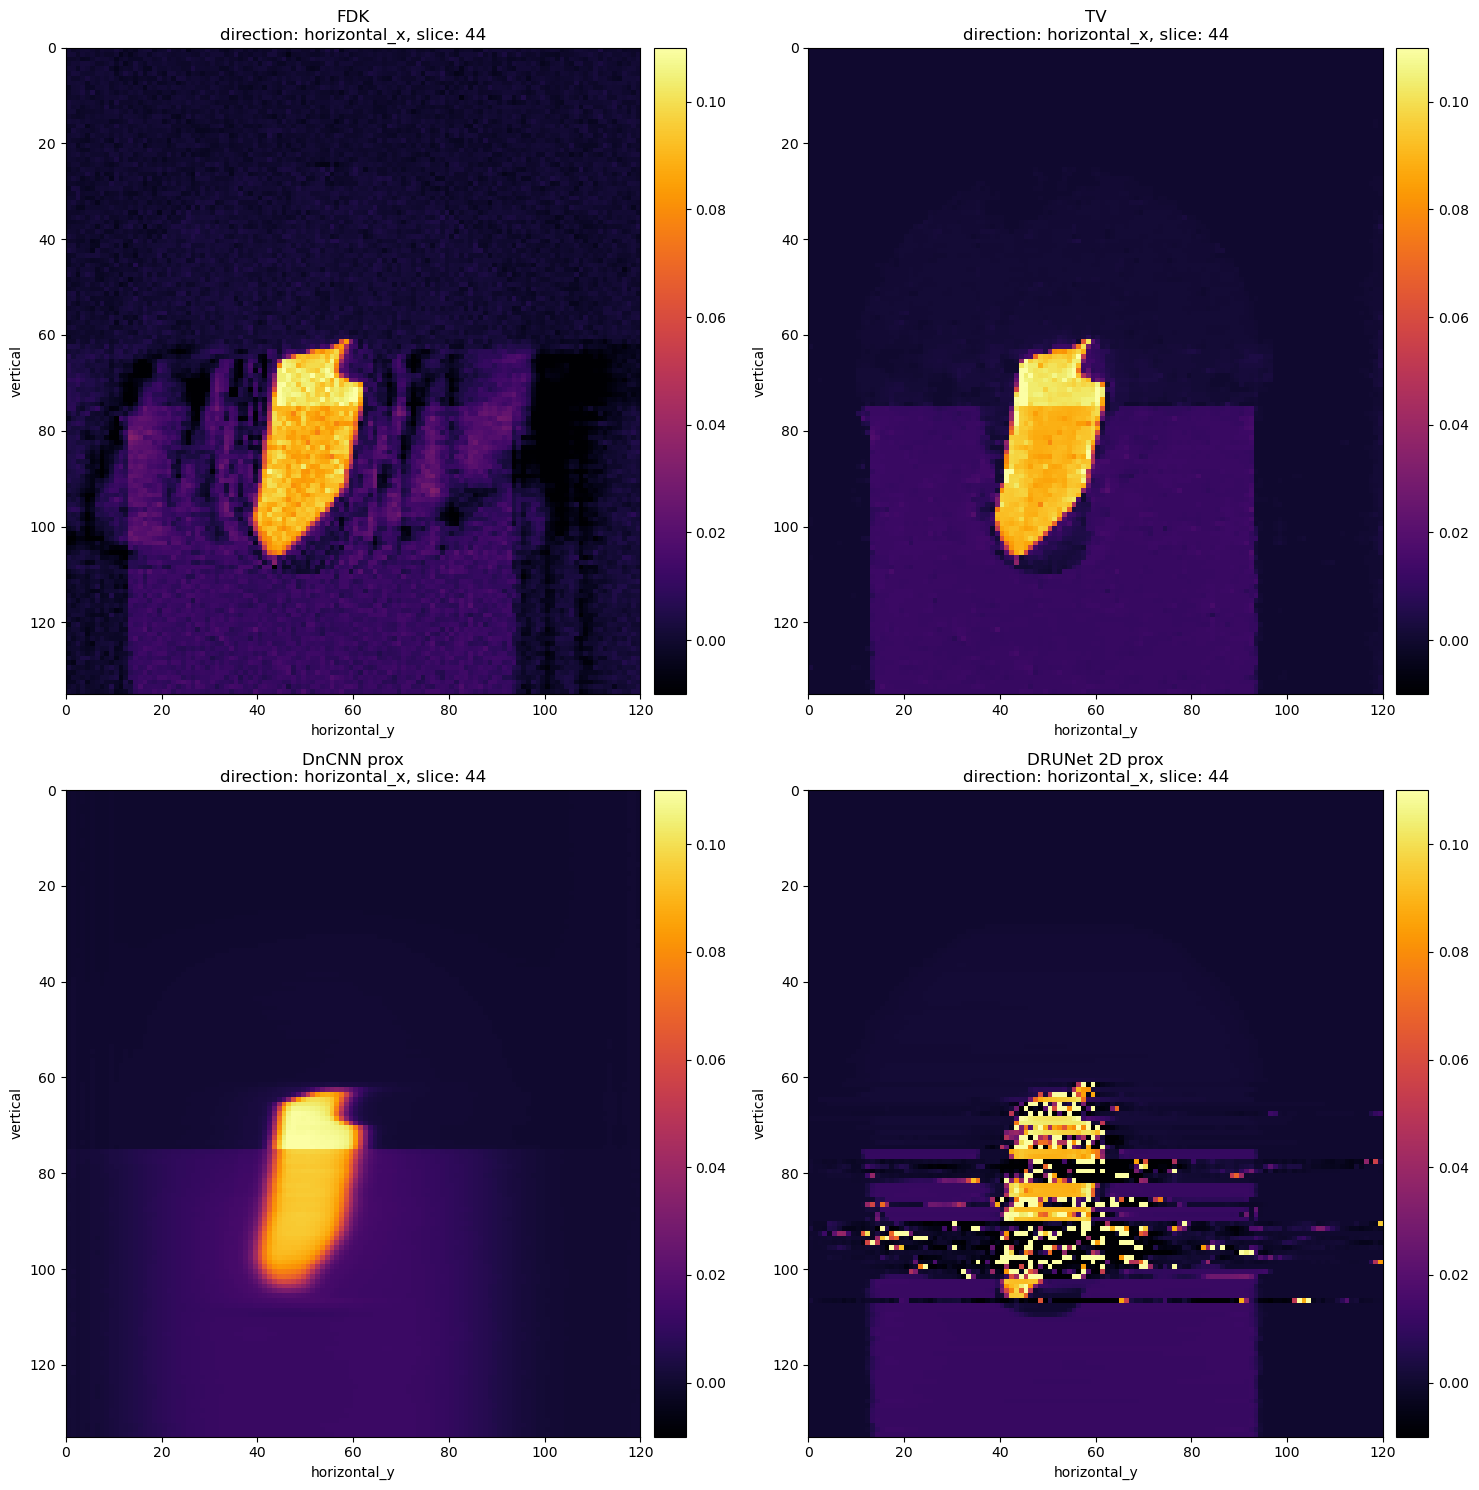

In [16]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution, myFISTADRUNet2D.solution], title=['FDK', 'TV' ,'DnCNN prox', 'DRUNet 2D prox'],
     slice_list=('horizontal_x',sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

In [17]:
import gc

Regulariser.function.model.to('cpu')
del Regulariser
gc.collect()
torch.cuda.empty_cache()

## FISTA with the proximal step a learned denoiser - DRUNet - noise level aware - applied three times! 

In [18]:
class DRUNetProximal3D(Function ):
    
    def __init__(self, device='cuda:1', batch_size=None ):
        self.device = torch.device('cuda:1')
        self.model = deepinv.models.DRUNet(in_channels=1, out_channels=1, pretrained='download', device=self.device)
        self.batch_size = batch_size
        super(DRUNetProximal3D, self).__init__()

    def __call__(self, x):
        return 0 
    
    def proximal(self, x, tau, out=None): 
        with torch.no_grad():
            x_torch = torch.tensor(x.array, device=self.device)

            x_torch = x_torch.squeeze(0).unsqueeze(1)
            
            x_torch= self.model(x_torch, tau)
            
            x_torch = x_torch.permute( 2, 1, 0, 3 )
            

            x_torch= self.model(x_torch, tau)
            x_torch = x_torch.permute( 2, 1, 0, 3 )
        
            x_torch = x_torch.permute( 3, 1, 2, 0 )
            
            x_torch= self.model(x_torch, tau)

            x_torch = x_torch.permute( 3, 1, 2, 0 )
            
            x_torch = x_torch.squeeze(1).unsqueeze(0)
        
        if out is None: 
            out = x.geometry.allocate(None)
        
        out.array[:] = x_torch.detach().cpu().numpy()
        return out 

  0%|          | 0/50 [00:00<?, ?it/s]

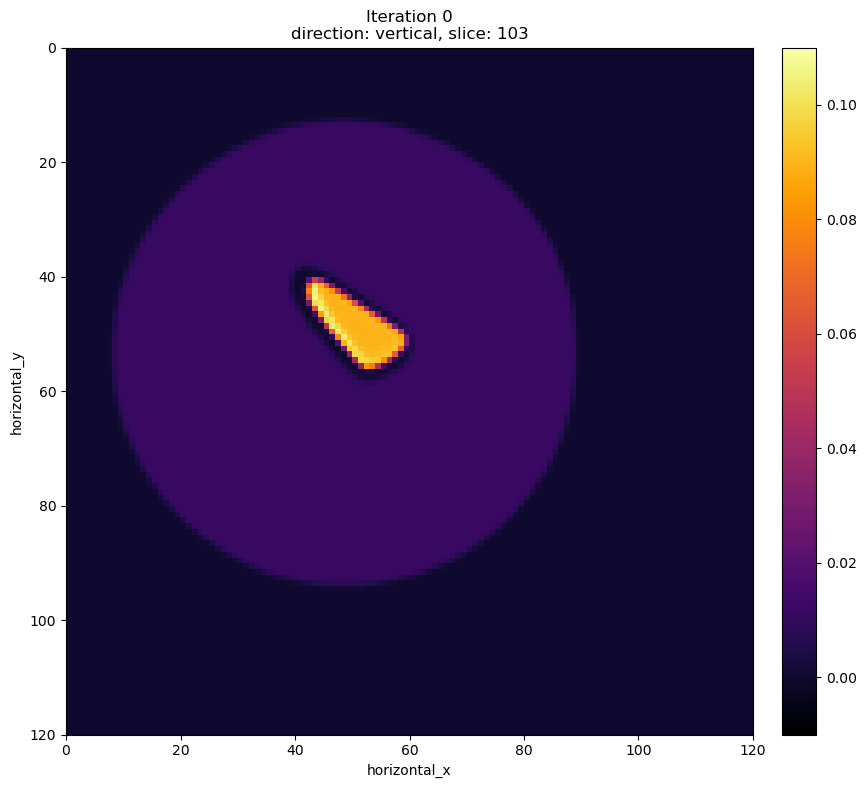

 51%|#####1    | 51/100 [00:00<?, ?it/s]

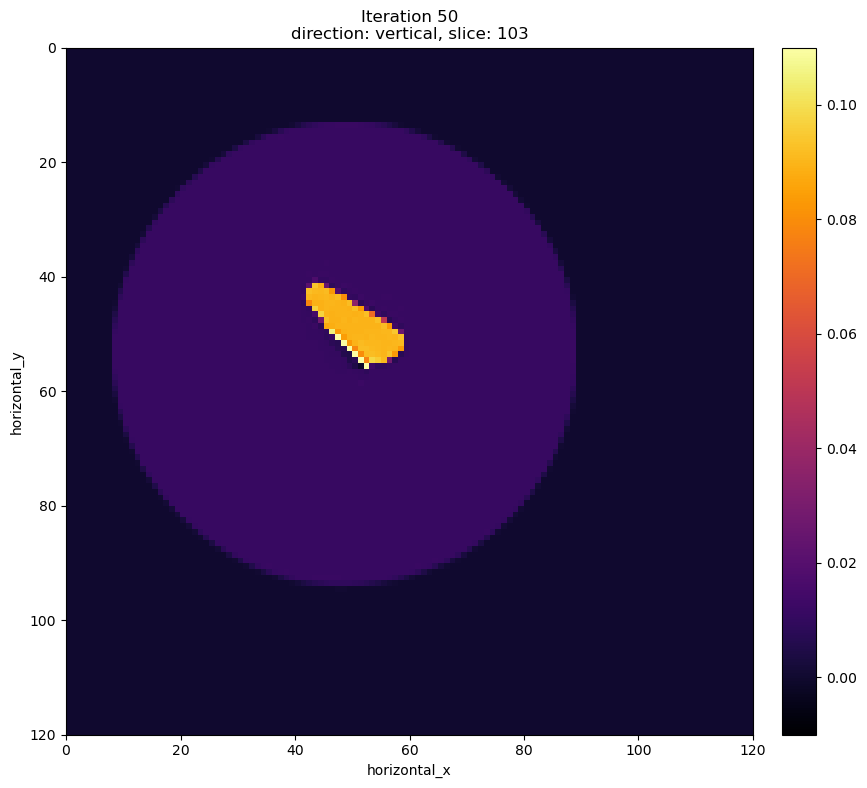

In [25]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha=3
Regulariser = alpha*DRUNetProximal3D(batch_size=5)
myFISTADRUNet3D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(2):
    myFISTADRUNet3D.run(50,verbose=1)
    show2D(myFISTADRUNet3D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


In [26]:
#TODO: look at how this objective value behaves 

In [27]:
import gc

Regulariser.function.model.to('cpu')
del Regulariser
gc.collect()
torch.cuda.empty_cache()

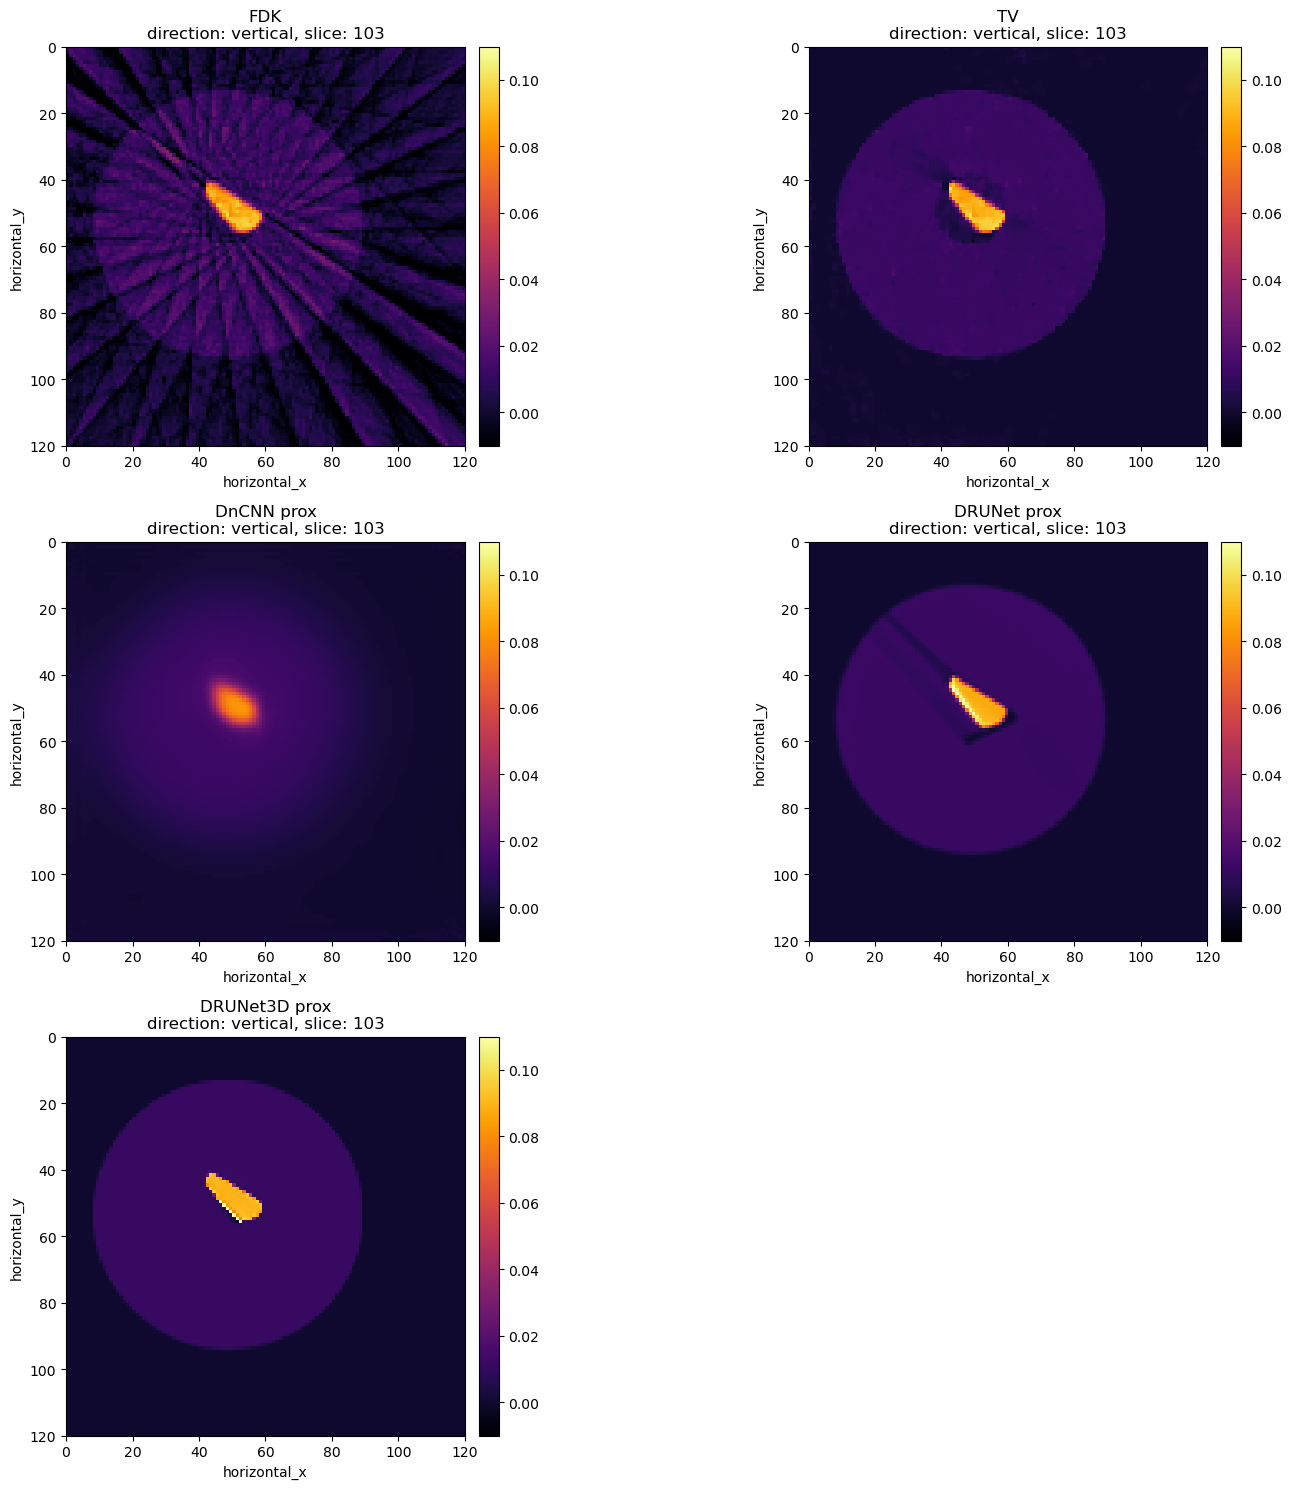

In [28]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution, myFISTADRUNet2D.solution, myFISTADRUNet3D.solution, ], title=['FDK', 'TV' , 'DnCNN prox',  'DRUNet prox', 'DRUNet3D prox'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

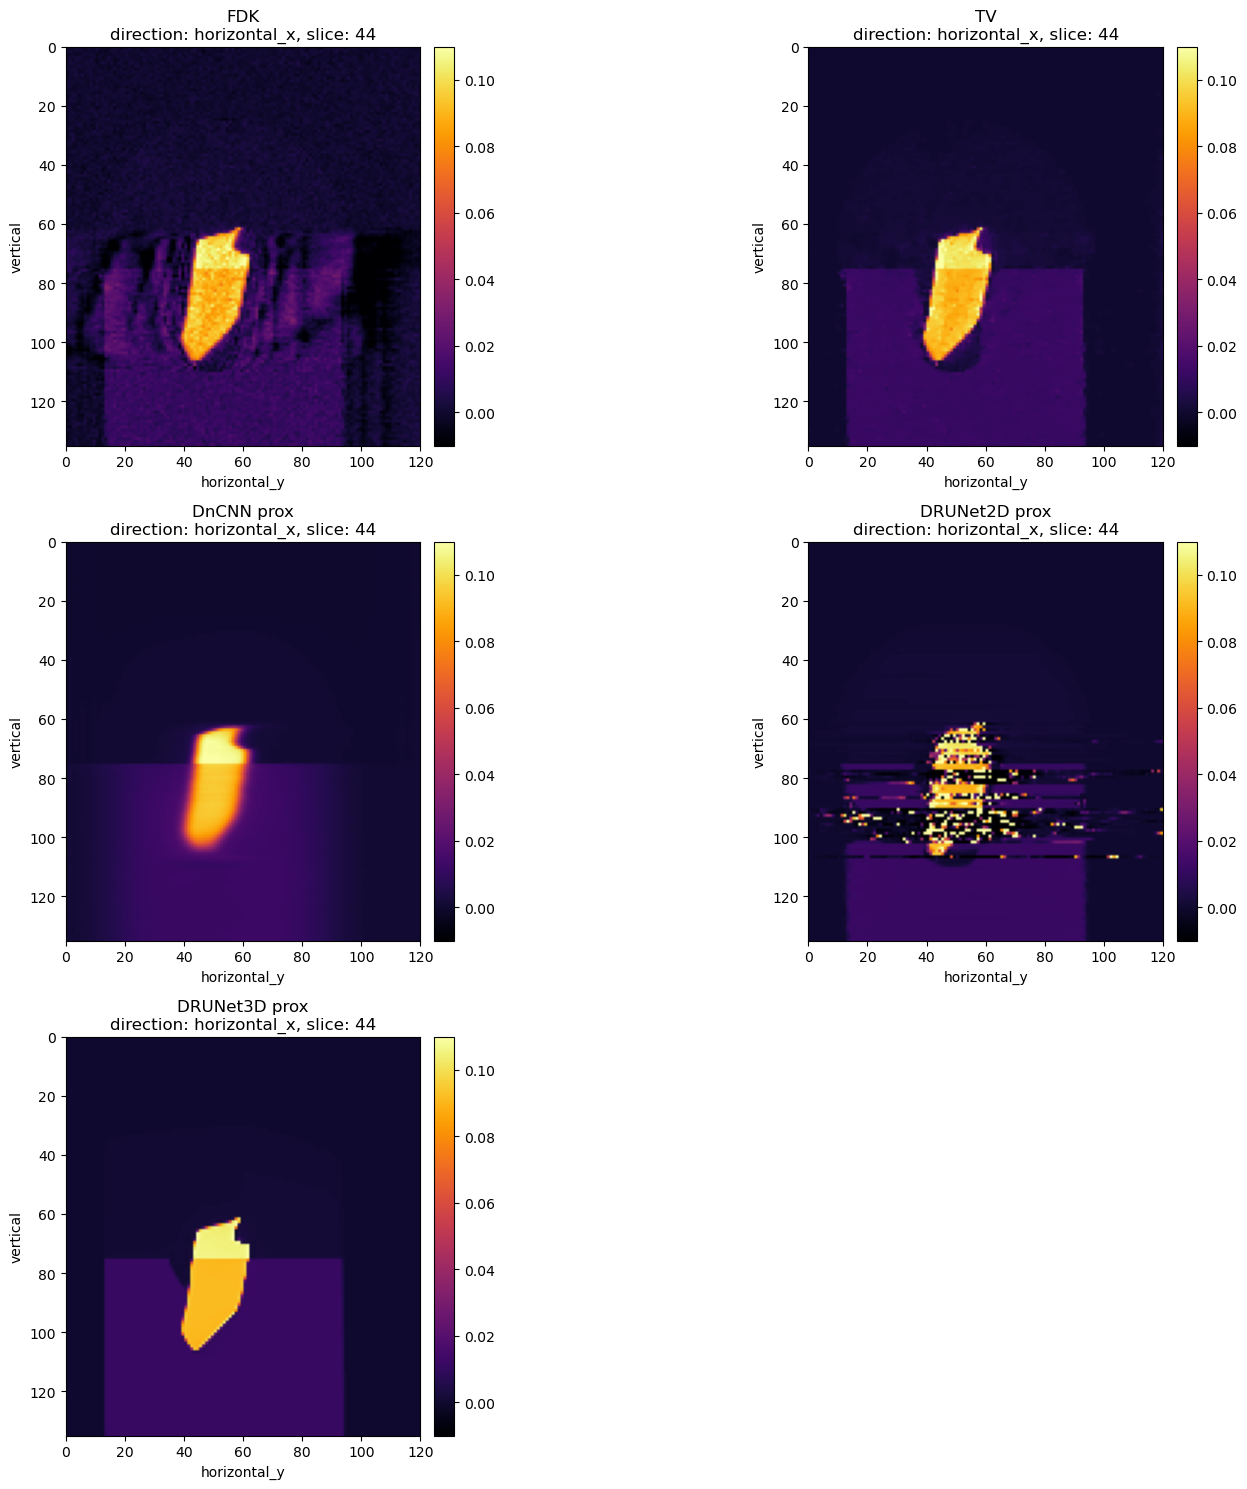

In [29]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution, myFISTADRUNet2D.solution, myFISTADRUNet3D.solution], title=['FDK', 'TV' , 'DnCNN prox', 'DRUNet2D prox', 'DRUNet3D prox'],
    slice_list=('horizontal_x',sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')